# Analytic Continuation

consider function
$$
f(z)=z^2 = x^2 - y^2 + 2ixy
$$
with $\epsilon = x + i y$. So
$$
u(x,y) = x^2 - y^2 \\
v(x,y) = 2xy
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from IPython.display import display

In [2]:
x, y = sp.symbols('x y', real=True)
z = (x+sp.I*y)
print('z**2:', sp.re(sp.expand(z**2)), ', ', sp.im(sp.expand(z**2)))
print('z**3:', sp.re(sp.expand(z**3)), ', ', sp.im(sp.expand(z**3)))

z**2: x**2 - y**2 ,  2*x*y
z**3: x**3 - 3*x*y**2 ,  3*x**2*y - y**3


In [4]:
# z**2
u = lambda x, y: x**2 - y**2
v = lambda x, y: 2*x*y

# # z**3
# u = lambda x, y: x**2 - y**2
# v = lambda x, y: 2*x*y

In [5]:
def _dtake(a, index, axis):
    '''numpy take a single index but keep dimensions.'''
    dims = [1 if i == axis else s for i, s in enumerate(a.shape)]
    return np.take(a=a, indices=index, axis=axis).reshape(dims)
    
def _take_many(f, indeces, axis):
    return (*[_dtake(f, i, axis) for i in indeces], )

def pad_left(f, axis):
    ''' makes left padding for calculating three-point
    difference estimate for the beginning point.
    '''
    f0, f1, f2 = _take_many(f, [0, 1, 2], axis)
    f_pad = np.concatenate([3*(f0 - f1) + f2, f], axis=axis)
    return f_pad

def pad_right(f, axis):
    ''' makes right padding for calculating three-point
    difference estimate for the end point.
    '''
    fm1, fm2, fm3 = _take_many(f, [-1, -2, -3], axis)
    f_pad = np.concatenate([f, 3*(fm1 - fm2) + fm3], axis=axis)
    return f_pad

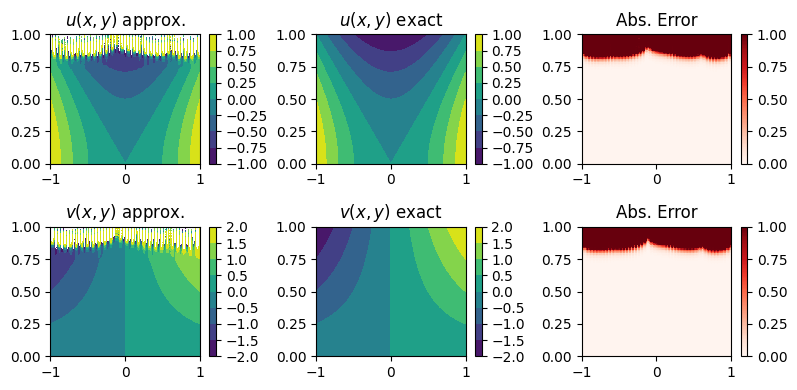

In [14]:
N = 100
xi = np.linspace(-1,1, N)
yj = np.linspace(0, 1, N)
dx = xi[1] - xi[0]
dy = yj[1] - yj[0]
X, Y = np.meshgrid(xi, yj, indexing='ij')

# Initialise it
ui0 = u(xi, yj[0])
vi0 = v(xi, yj[0])
ui1 = u(xi, yj[1])
vi1 = v(xi, yj[1])

# ui0_pad = pad_right(pad_left(ui0, axis=0), axis=0)
# vi0_pad = pad_right(pad_left(vi0, axis=0), axis=0)

# du0_pad = np.diff(ui0_pad)
# dv0_pad = np.diff(vi0_pad)
# vi1 = 1/2 * (du0_pad[1:] + du0_pad[:-1]) + vi0
# ui1 = -1/2 * (dv0_pad[1:] + dv0_pad[:-1]) + ui0

U, V = np.zeros_like(X), np.zeros_like(X)
U[:, 0] = ui0
V[:, 0] = vi0
U[:, 1] = ui1
V[:, 1] = vi1

for j in range(2,N):
    u_pad = pad_right(pad_left(U[:, j-1], axis=0), axis=0)
    v_pad = pad_right(pad_left(V[:, j-1], axis=0), axis=0)
    du_pad = np.diff(u_pad)
    dv_pad = np.diff(v_pad)
    V[:, j] = dy/dx * (du_pad[1:] + du_pad[:-1]) + V[:, j-2]
    U[:, j] = - dy/dx * (dv_pad[1:] + dv_pad[:-1]) + U[:, j-2]

fig, axes = plt.subplots(2, 3, figsize=(8, 4))
clevels = np.linspace(np.round(np.min(u(X,Y))), np.round(np.max(u(X,Y))), 9)
cont = axes[0, 0].contourf(X, Y, U, clevels)
plt.colorbar(cont)
axes[0, 0].set_title(r'$u(x,y)$ approx.')

cont = axes[0, 1].contourf(X, Y, u(X, Y), clevels)
plt.colorbar(cont)
axes[0, 1].set_title(r'$u(x,y)$ exact')

cont = axes[0, 2].contourf(X, Y, np.abs(U - u(X, Y)), cmap='Reds', vmin=0, vmax=1)
cont = axes[0, 2].contourf(X, Y, np.abs(U - u(X, Y)), np.linspace(0, 1, 99), cmap='Reds')
plt.colorbar(cont, ticks=np.linspace(0, 1, 5))
axes[0, 2].set_title(r'Abs. Error')

clevels = np.linspace(np.round(np.min(v(X,Y))), np.round(np.max(v(X,Y))), 9)
cont = axes[1, 0].contourf(X, Y, V, clevels)
plt.colorbar(cont)
axes[1, 0].set_title(r'$v(x,y)$ approx.')

cont = axes[1, 1].contourf(X, Y, v(X, Y), clevels)
plt.colorbar(cont)
axes[1, 1].set_title(r'$v(x,y)$ exact')

cont = axes[1, 2].contourf(X, Y, np.abs(V - v(X, Y)), cmap='Reds', vmin=0, vmax=1)
cont = axes[1, 2].contourf(X, Y, np.abs(V - v(X, Y)), np.linspace(0, 1, 99), cmap='Reds')
plt.colorbar(cont, ticks=np.linspace(0, 1, 5))
axes[1, 2].set_title(r'Abs. Error')

plt.tight_layout()
plt.savefig('./plots/anal_cont_m1.png', dpi=600)
plt.show()

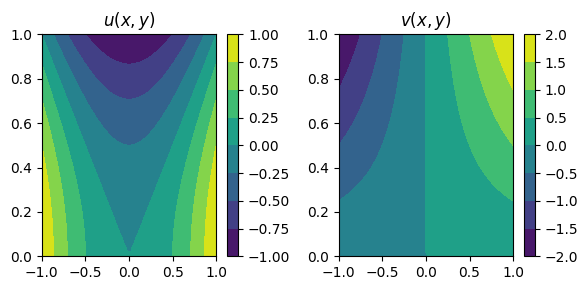

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

cont = axes[0].contourf(X, Y, u(X, Y))
plt.colorbar(cont)
axes[0].set_title(r'$u(x,y)$')

cont = axes[1].contourf(X, Y, v(X, Y))
plt.colorbar(cont)
axes[1].set_title(r'$v(x,y)$')

plt.tight_layout()
plt.show()

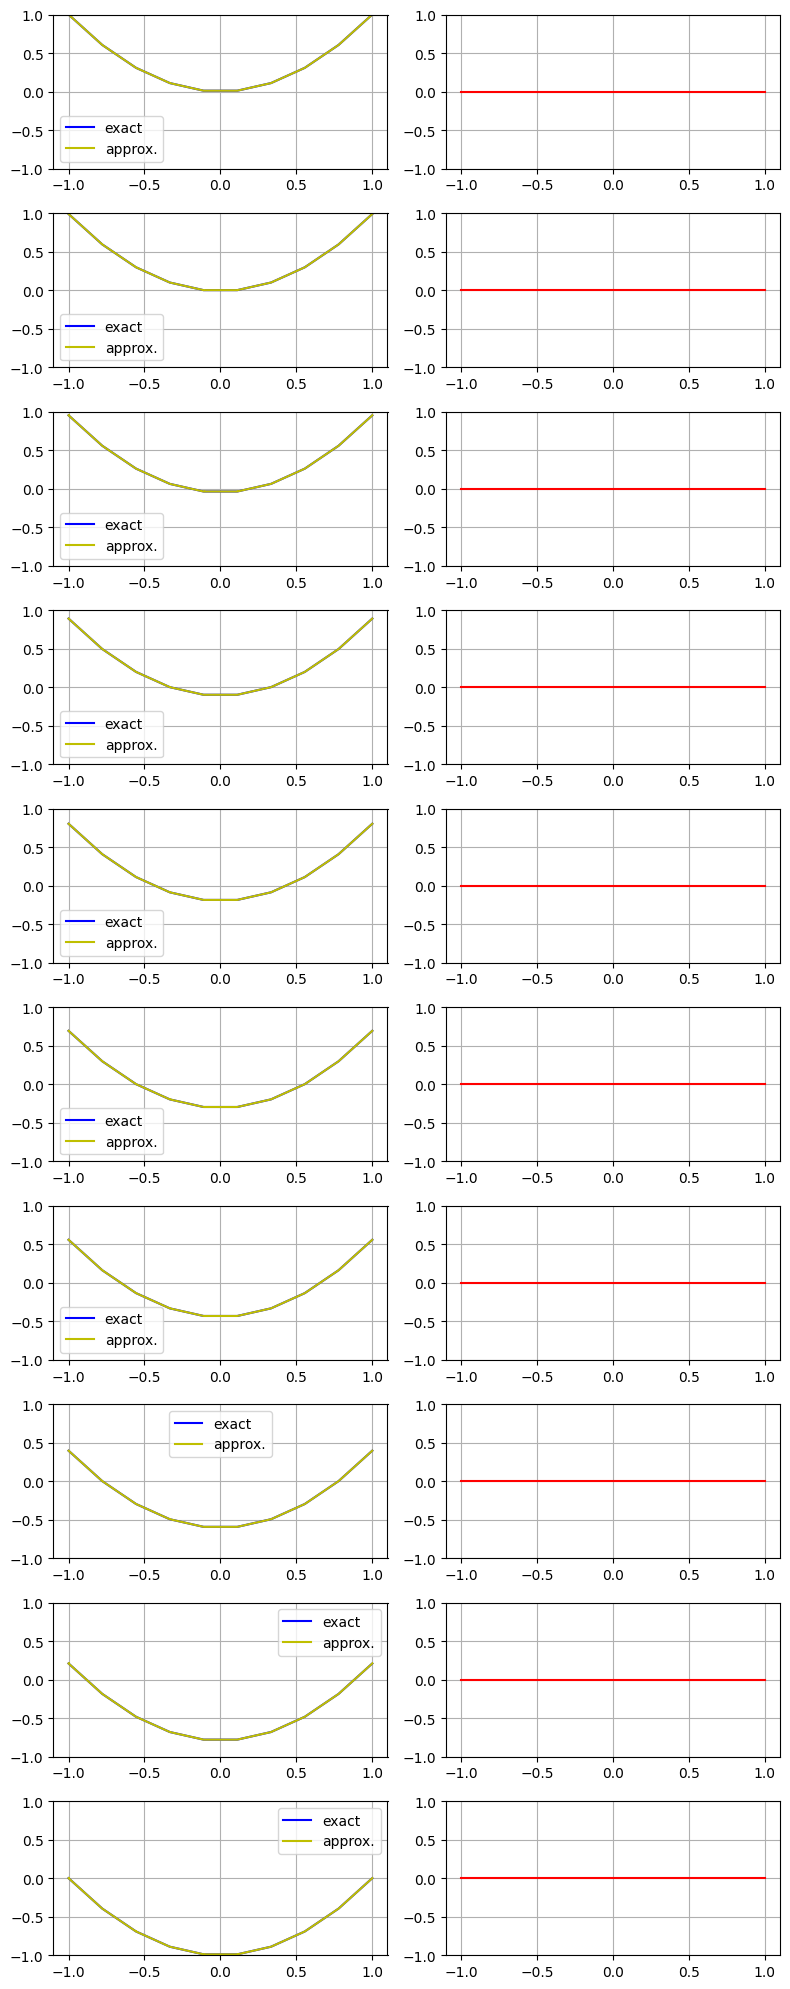

In [22]:
nrows = 10
fig, axes = plt.subplots(nrows, 2, figsize=(8, 2*nrows))

for j in range(nrows):
    i = j*int(N/nrows)

    axes[j, 0].plot(xi, u(X, Y)[:, i], '-', color='b', label='exact')
    axes[j, 0].plot(xi, U[:, i], '-,', color='y', label='approx.')
    axes[j, 0].set_ylim(-1,1)
    axes[j, 0].grid()
    axes[j, 0].legend()

    axes[j, 1].plot(xi, u(X, Y)[:, i] - U[:, i], color='r')
    axes[j, 1].set_ylim(-1,1)
    axes[j, 1].grid()

plt.tight_layout()

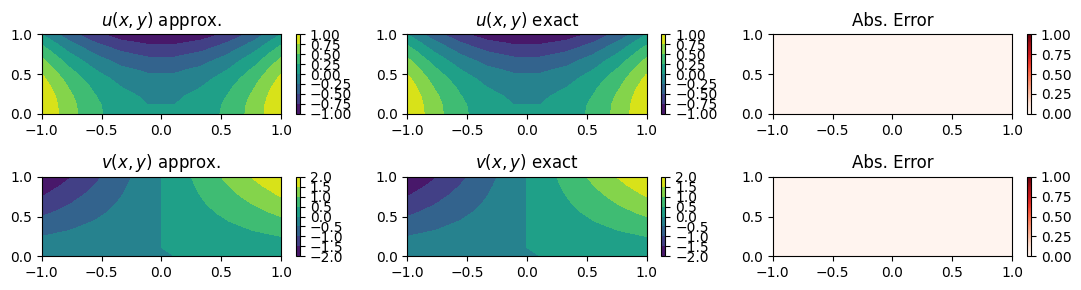